## PREP & DATA LOADING

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import Lasso, lasso_path

from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score, KFold

from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc,accuracy_score, precision_score, recall_score, f1_score

In [3]:
from sklearn import svm
from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score

In [4]:
# for pca to fix colinearity 
from sklearn.decomposition import PCA

# checking olinearity 
from statsmodels.stats.outliers_influence import variance_inflation_factor 

In [30]:
#reading file

df= pd.read_csv('/Users/morgan/Desktop/SEIS 763 ML/FINAL PROJECT/Final Project Data Files/ML_job_postings_finale_ready_v2.csv',header=0)
df.head()

,job_id,title,work_type,description,location,zip_code,min_salary,max_salary,normalized_salary,views,...,sector,city,state,name,latitude,longitude,gdp,income,region,moving_score
0,1014822088,Marketing Specialist,FULL_TIME,About TrackerTracker is a leading global cloud...,United States,NaN,70000.0,80000.0,75000.0,7.0,...,Information Technology,United States,US,Remote,NaN,NaN,483162.0,416325.0,Plains,50.000000
1,3189117072,Client Service Associate / Practice Manager,FULL_TIME,Company OverviewSignature Estate and Investmen...,"Redondo Beach, CA",90277.0,70000.0,100000.0,85000.0,6.0,...,Energy,Redondo Beach,CA,California,36.778261,-119.417932,3870379.0,3166135.0,Far West,4.214518
2,3260455681,Operations Specialist,FULL_TIME,Weyerhaeuser is searching for a Operations Spe...,"Castle Rock, WA",98611.0,72742.0,109113.0,90927.5,18.0,...,Materials,Castle Rock,WA,Washington,47.751074,-120.740139,807865.0,632296.0,Far West,4.703287
3,3277232283,HR & Administrative Assistant,FULL_TIME,HR & Administrative CoordinatorWork is Remote ...,United States,NaN,55000.0,72000.0,63500.0,59.0,...,Energy,United States,US,Remote,NaN,NaN,483162.0,416325.0,Plains,50.000000
4,3297645846,Contract Administrator,FULL_TIME,Contract AdministratorSummary of PositionThe C...,"Broomfield, CO",80020.0,74400.0,90000.0,82200.0,6.0,...,Materials,Broomfield,CO,Colorado,39.550051,-105.782067,529627.0,470606.0,Rocky Mountain,8.368978


In [32]:
df.shape

(3902, 50)

In [34]:
df.dtypes

job_id                           int64
title                           object
work_type                       object
description                     object
location                        object
zip_code                       float64
min_salary                     float64
max_salary                     float64
normalized_salary              float64
views                          float64
original_listed_time            object
expiry                          object
day_posting                      int64
is_data_related                   bool
formatted_experience_level      object
degree_level                    object
job_classification              object
soft_skills                     object
programming_languages_score      int64
analysis_statistics_score        int64
machine_learning_score           int64
data_visualization_score         int64
cloud_platform_score             int64
database_score                   int64
big_data_tools_score             int64
big_data_score           

In [36]:
df['region'].unique()

array(['Plains', 'Far West', 'Rocky Mountain ', 'New England ',
       'Southeast ', 'Southwest ', 'Mideast ', 'Great Lakes ', 'Plains '],
      dtype=object)

## 2. FUNCTION SECTIONS

In [39]:
def fill_na_with_mean(df, columns):
  """
  Fills missing values in specified columns with their respective column means.

  Args:
    df: The DataFrame.
    columns: A list of column names to fill missing values.

  Returns:
    The DataFrame with missing values filled.
  """

  for col in columns:
    mean_value = df[col].mean()
    df[col].fillna(mean_value, inplace=True)

  return df

In [41]:
def apply_pca(df, columns, new_column_name):
    """
    Applies PCA to the specified columns and adds the first principal component to the DataFrame.

    Args:
        df: The DataFrame.
        columns: A list of column names to apply PCA to.
        new_column_name: The name of the new column to store the first principal component.

    Returns:
        The DataFrame with the added principal component.
    """

    pca = PCA(n_components=1)
    pca_result = pca.fit_transform(df[columns])
    df[new_column_name] = pca_result.flatten()
    df = df.drop(columns, axis=1)

    return df

In [43]:
def plot_histograms(df, columns, nrows=3, ncols=3, figsize=(15, 10)):
    """
    Plots histograms for the specified columns in a DataFrame.

    Args:
        df: The DataFrame containing the data.
        columns: A list of column names to plot.
        nrows: Number of rows in the subplot grid.
        ncols: Number of columns in the subplot grid.
        figsize: Figure size in inches.
    """

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.histplot(df[col], ax=axes[i], kde=True)
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [45]:
def remove_outliers_zscore_inplace(df, columns, threshold=3):
    """
    Removes outliers from a DataFrame based on z-scores, modifying the DataFrame in-place.

    Args:
        df: The DataFrame to process.
        columns: A list of column names to consider for outlier detection.
        threshold: The z-score threshold for identifying outliers.
    """

    for col in columns:
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        df.drop(df[z_scores > threshold].index, inplace=True)

In [47]:
# Melt the DataFrame to a long format for easier plotting
# Select the columns of interest
def boxplot_check(df,columns):
    """
    Plot box-plot to identify outliers.

    Args:
        df: The DataFrame to process.
        columns: A list of column names to consider for ploting and outlier detection.

    Returns:
        boxplots
    """
    df_melted = df[columns].melt()
    
    # Create a boxplot
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='variable', y='value', data=df_melted)
    plt.title('Boxplot of Numerical Features')
    plt.xlabel('Feature')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.show()

In [49]:
def plot_scatter_plots(df, target_col, predictors):
    """
    Plots scatter plots of the target variable against each predictor variable.

    Args:
        df: The DataFrame containing the data.
        target_col: The name of the target column.
        predictors: A list of predictor column names.
    """

    num_plots = len(predictors)
    ncols = 3  # Number of columns in the subplot grid
    nrows = (num_plots - 1) // ncols + 1

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
    axes = axes.flatten()

    for i, predictor in enumerate(predictors):
        sns.scatterplot(x=target_col, y=predictor, data=df, ax=axes[i])
        axes[i].set_title(f'{target_col} vs {predictor}')

    plt.tight_layout()
    plt.show()

In [51]:
def check_collinearity(df):
    """
    Checks for collinearity in a DataFrame.

    Args:
        df: The DataFrame to check.

    Returns:
        None
    """

    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Visualize the correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

    # Calculate VIF for each variable
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

    print(vif_data)


In [53]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [55]:
def plot_roc_curves(y_true, y_proba):

    y_proba = np.column_stack((1 - y_proba, y_proba))
    
    # For class 0
    fpr_0, tpr_0, _ = roc_curve(y_true, 1-y_proba[:, 0], pos_label=0)
    roc_auc_0 = auc(fpr_0, tpr_0)

    # For class 1
    fpr_1, tpr_1, _ = roc_curve(y_true, 1-y_proba[:, 1], pos_label=1)
    roc_auc_1 = auc(fpr_1, tpr_1)
    
    # Plotting
    plt.figure()
    plt.plot(fpr_0, tpr_0, label=f'Class 0 (AUC = {roc_auc_0:.2f})', color='blue')
    plt.plot(fpr_1, tpr_1, label=f'Class 1 (AUC = {roc_auc_1:.2f})', color='red')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Both Classes')
    plt.legend()
    plt.grid()
    plt.show()
    
    print(f'Class 0 AUC: {roc_auc_0:.2f}')
    print(f'Class 1 AUC: {roc_auc_1:.2f}')

In [57]:
# Function: Generate Classification Report with Confusion Matrix
def classification_report_analysis(y, x):
    
    # Confusion Matrix
    confusion_mtx = pd.crosstab(y, y_pred, rownames=['Actual'], colnames=['Predicted'])
    plt.figure(figsize=(5, 4))
    sn.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.show()
    
    # Classification Report
    stats = classification_report(y, y_pred)
    print("Classification Report:\n", stats)


In [59]:
def extract_f1_scores(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    f1_scores = [report[class_label]['f1-score'] for class_label in report.keys() if class_label != 'accuracy']
    return f1_scores
       

In [61]:
# Function to create a 3D scatter plot
def plot_2d_scatter(x, y):
    """3D Scatter plot using the first three features."""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, s=50)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title('3D Scatter Plot of First 3 Features')
    plt.show()

In [63]:
# Run SVM with RBF kernel
def run_svm_rbf(x, y, clf):
    
    clf.fit(x, y)
    y_pred = clf.predict(x)
    y_proba = clf.predict_proba(x)

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    
    print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}')
    return clf, y_proba, y_pred

In [65]:
apply_pca(df, ['income','gdp'], 'economic_score')
apply_pca(df, ['employee_count','follower_count'], 'company_score')

,job_id,title,work_type,description,location,zip_code,min_salary,max_salary,normalized_salary,views,...,state,name,latitude,longitude,gdp,income,region,moving_score,economic_score,company_score
0,1014822088,Marketing Specialist,FULL_TIME,About TrackerTracker is a leading global cloud...,United States,NaN,70000.0,80000.0,75000.0,7.0,...,US,Remote,NaN,NaN,483162.0,416325.0,Plains,50.000000,-1.283429e+06,-1.807878e+06
1,3189117072,Client Service Associate / Practice Manager,FULL_TIME,Company OverviewSignature Estate and Investmen...,"Redondo Beach, CA",90277.0,70000.0,100000.0,85000.0,6.0,...,CA,California,36.778261,-119.417932,3870379.0,3166135.0,Far West,4.214518,3.079390e+06,-1.808273e+06
2,3260455681,Operations Specialist,FULL_TIME,Weyerhaeuser is searching for a Operations Spe...,"Castle Rock, WA",98611.0,72742.0,109113.0,90927.5,18.0,...,WA,Washington,47.751074,-120.740139,807865.0,632296.0,Far West,4.703287,-8.950336e+05,-1.720443e+06
3,3277232283,HR & Administrative Assistant,FULL_TIME,HR & Administrative CoordinatorWork is Remote ...,United States,NaN,55000.0,72000.0,63500.0,59.0,...,US,Remote,NaN,NaN,483162.0,416325.0,Plains,50.000000,-1.283429e+06,-1.811867e+06
4,3297645846,Contract Administrator,FULL_TIME,Contract AdministratorSummary of PositionThe C...,"Broomfield, CO",80020.0,74400.0,90000.0,82200.0,6.0,...,CO,Colorado,39.550051,-105.782067,529627.0,470606.0,Rocky Mountain,8.368978,-1.213210e+06,-1.812367e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,3906260060,"Principal/Senior, Program Manager- Global Sale...",FULL_TIME,Your work days are brighter here.\n\nAt Workda...,"Chicago, IL",60601.0,140800.0,239300.0,190050.0,4.0,...,IL,Illinois,40.633125,-89.398528,1098346.0,906648.0,Great Lakes,17.304814,-4.967535e+05,-8.529567e+05
3898,3906260068,Senior Associate Quality Assurance Engineer,FULL_TIME,Your work days are brighter here.\n\nAt Workda...,"Atlanta, GA",30303.0,74500.0,151200.0,112850.0,4.0,...,GA,Georgia,32.157435,-82.907123,831828.0,660447.0,Southeast,5.941396,-8.587215e+05,-8.529567e+05
3899,3906260689,iOS Developer,FULL_TIME,VW. Two letters. Endless opportunities. A brig...,"Belmont, CA",94002.0,128400.0,190000.0,159200.0,5.0,...,CA,California,36.778261,-119.417932,3870379.0,3166135.0,Far West,4.214518,3.079390e+06,-1.809539e+06
3900,3906262009,Senior Business Intelligence Developer,CONTRACT,Senior Business Intelligence DeveloperLos Ange...,"Los Angeles, CA",90001.0,133120.0,141440.0,137280.0,3.0,...,CA,California,36.778261,-119.417932,3870379.0,3166135.0,Far West,4.214518,3.079390e+06,-1.730832e+06


In [67]:
# Remove all white spaces
df['region'] = df['region'].str.replace(' ', '')

## 3. Model with top predictors building

### - predictors testing and picking

In [73]:
df.columns

Index(['job_id', 'title', 'work_type', 'description', 'location', 'zip_code',
       'min_salary', 'max_salary', 'normalized_salary', 'views',
       'original_listed_time', 'expiry', 'day_posting', 'is_data_related',
       'formatted_experience_level', 'degree_level', 'job_classification',
       'soft_skills', 'programming_languages_score',
       'analysis_statistics_score', 'machine_learning_score',
       'data_visualization_score', 'cloud_platform_score', 'database_score',
       'big_data_tools_score', 'big_data_score', 'business_engineering_score',
       'company_id', 'company_name', 'company desc', 'company_size', 'country',
       'headquarter state', 'headquarter city', 'headquarter addr',
       'headquarter zipcode', 'industry', 'speciality', 'employee_count',
       'follower_count', 'sector', 'city', 'state', 'name', 'latitude',
       'longitude', 'gdp', 'income', 'region', 'moving_score',
       'economic_score', 'company_score'],
      dtype='object')

In [75]:
cols=[ 'normalized_salary', 'job_classification','programming_languages_score',
      'machine_learning_score','company_size',  'sector', 'region', 'economic_score', 'company_score']

In [77]:
X_pca = df[cols]
X_pca=pd.get_dummies(X_pca, drop_first=True)
print(X_pca.shape)

(3902, 25)


In [79]:
fill_na_with_mean(X_pca,X_pca.columns)

,normalized_salary,programming_languages_score,machine_learning_score,company_size,economic_score,company_score,job_classification_Engineering,job_classification_Other,sector_Consumer Discretionary,sector_Consumer Staples,...,sector_Materials,sector_Real Estate,sector_Utilities,region_GreatLakes,region_Mideast,region_NewEngland,region_Plains,region_RockyMountain,region_Southeast,region_Southwest
0,75000.0,1,1,2.000000,-1.283429e+06,-1.807878e+06,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,85000.0,1,1,2.000000,3.079390e+06,-1.808273e+06,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,90927.5,1,1,7.000000,-8.950336e+05,-1.720443e+06,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,63500.0,1,1,5.251906,-1.283429e+06,-1.811867e+06,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
4,82200.0,1,1,5.000000,-1.213210e+06,-1.812367e+06,True,False,False,False,...,True,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,190050.0,1,1,7.000000,-4.967535e+05,-8.529567e+05,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3898,112850.0,3,1,7.000000,-8.587215e+05,-8.529567e+05,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3899,159200.0,4,1,3.000000,3.079390e+06,-1.809539e+06,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3900,137280.0,2,1,5.000000,3.079390e+06,-1.730832e+06,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [81]:
remove_outliers_zscore_inplace(X_pca,X_pca.columns, threshold=3)

In [83]:
# standardization

x_pca_scaled=preprocessing.scale(X_pca)

In [85]:
# Convert clu_scaled back to DataFrame
X_pca = pd.DataFrame(x_pca_scaled, columns=X_pca.columns)
print(X_pca.shape)

(2053, 25)


In [87]:
X_pca.columns

Index(['normalized_salary', 'programming_languages_score',
       'machine_learning_score', 'company_size', 'economic_score',
       'company_score', 'job_classification_Engineering',
       'job_classification_Other', 'sector_Consumer Discretionary',
       'sector_Consumer Staples', 'sector_Energy', 'sector_Financials',
       'sector_Health Care', 'sector_Industrials',
       'sector_Information Technology', 'sector_Materials',
       'sector_Real Estate', 'sector_Utilities', 'region_GreatLakes',
       'region_Mideast', 'region_NewEngland', 'region_Plains',
       'region_RockyMountain', 'region_Southeast', 'region_Southwest'],
      dtype='object')

In [89]:
X_pca.shape

(2053, 25)

In [91]:
X=X_pca.drop('normalized_salary',axis=1)
y=X_pca['normalized_salary']

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)


# Fit the model to the training data
rf_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_regressor.predict(X_test)

# Evaluate the   model (e.g., using Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.8783645472599922


In [92]:
# Get feature importances
importances = rf_regressor.feature_importances_

# Sort   features by importance
indices = np.argsort(importances)[::-1]

# Select top 5 features
top_5_features = X.columns[indices[:5]]

# Create a new DataFrame with top 5 features
X_top5 = X[top_5_features]

In [95]:
X_top5

,company_score,economic_score,company_size,programming_languages_score,job_classification_Engineering
0,-0.404672,-0.770599,-1.560853,-0.468130,0.638822
1,-0.404853,1.703499,-1.560853,-0.468130,0.638822
2,-0.406500,-0.770599,0.078854,-0.468130,-1.565382
3,-0.406142,-0.529753,-2.065082,-0.468130,-1.565382
4,-0.388814,-0.990308,0.960293,-0.468130,0.638822
...,...,...,...,...,...
2048,-0.382124,-0.550345,-0.048165,0.885491,0.638822
2049,0.033076,-0.529753,0.960293,2.239111,0.638822
2050,-0.405433,1.703499,-1.056623,3.592731,0.638822
2051,-0.369353,1.703499,-0.048165,0.885491,0.638822


###  - MODEL BUILDING

In [102]:
#define IVs and DV

svm_x=X_pca[['company_score', 'economic_score', 'company_size','programming_languages_score','job_classification_Engineering']]
svm_y=(X_pca['normalized_salary']>0.5).astype(int)

In [104]:
X_pca['normalized_salary'].describe()

count    2.053000e+03
mean     6.229795e-17
std      1.000244e+00
min     -1.650566e+00
25%     -7.200983e-01
50%     -1.495283e-01
75%      4.849454e-01
max      1.104242e+01
Name: normalized_salary, dtype: float64

In [106]:
# Function to create a 3D scatter plot for clustering visualization
def plot_3d_scatter(x, y, feature_names=None):
    """
    3D Scatter plot for clustering using three features.
    Parameters:
        x (array-like): Feature matrix (n_samples, n_features). The first three columns will be used for the 3D plot.
        y (array-like): Labels or cluster assignments (n_samples,).
        feature_names (list): Optional. List of feature names for axes labels.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plotting the first three features
    ax.scatter(x.iloc[:, 0], x.iloc[:, 1], x.iloc[:, 2], c=y, cmap=plt.cm.coolwarm, s=50)
    
    # Setting axis labels
    if feature_names:
        ax.set_xlabel(feature_names[0])
        ax.set_ylabel(feature_names[1])
        ax.set_zlabel(feature_names[2])
    else:
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_zlabel('Feature 3')
    
    ax.set_title('3D Scatter Plot of Clusters')
    plt.show()

In [108]:
X_pca['normalized_salary'].describe()
svm_y.unique()

array([0, 1])

In [110]:
# Professor Lai codes for re-standardization/Z-score
svm_x_s=preprocessing.scale(svm_x)

In [112]:
# Train-test split
#80% for training, 20% for testing

X_train, X_test, y_train, y_test = train_test_split(svm_x_s, svm_y, test_size=0.3, random_state=42)

In [114]:
# Define different values for C, gamma, and alpha
C_values = [1,10, 100,500]
gamma_values = [0.1,1, 10,50]
alpha_values = np.arange(0.0000001, 1, 0.5)

# Iterate through all combinations of C and gamma
for C in C_values:
    for gamma in gamma_values:
        # Define the SVC model with current C and gamma
        clf = SVC(kernel='rbf', C=C, gamma=gamma, probability=True)
        
        # Fit the model on the dataset (x, y)
        clf.fit(X_train, y_train)
        
        # Iterate through alpha values and train again with the same SVC
        print(f"Results for C={C}, gamma={gamma}:")
        for alpha in alpha_values:
            # Fit the same SVC with adjusted data or weights if needed
            clf.fit(X_train, y_train)  # Optionally include regularization if supported
            
            # Output the coefficients, intercept, and alpha
            try:
                # Attempt to access coefficients (only works for linear kernels)
                coef = np.round(clf.coef_, 3)
            except AttributeError:
                coef = "N/A (not accessible for RBF kernel)"
            
            # Print current results
            print(f"Alpha: {np.round(alpha, 7)}, Coef: {coef}, Intercept: {np.round(clf.intercept_, 3)}")
        
        print("-" * 50)

Results for C=1, gamma=0.1:
Alpha: 1e-07, Coef: N/A (not accessible for RBF kernel), Intercept: [-0.935]
Alpha: 0.5000001, Coef: N/A (not accessible for RBF kernel), Intercept: [-0.935]
--------------------------------------------------
Results for C=1, gamma=1:
Alpha: 1e-07, Coef: N/A (not accessible for RBF kernel), Intercept: [-0.614]
Alpha: 0.5000001, Coef: N/A (not accessible for RBF kernel), Intercept: [-0.614]
--------------------------------------------------
Results for C=1, gamma=10:
Alpha: 1e-07, Coef: N/A (not accessible for RBF kernel), Intercept: [-0.596]
Alpha: 0.5000001, Coef: N/A (not accessible for RBF kernel), Intercept: [-0.596]
--------------------------------------------------
Results for C=1, gamma=50:
Alpha: 1e-07, Coef: N/A (not accessible for RBF kernel), Intercept: [-0.604]
Alpha: 0.5000001, Coef: N/A (not accessible for RBF kernel), Intercept: [-0.604]
--------------------------------------------------
Results for C=10, gamma=0.1:
Alpha: 1e-07, Coef: N/A (no

In [116]:
# Prepare to store results
results = []


# Iterate over the models
for C in C_values:
    for gamma in gamma_values:
        clf = SVC(kernel='rbf', C=C, gamma=gamma, probability=True)
        clf.fit(svm_x_s, svm_y)  # Fit the model on training data

        # Calculate train and test accuracy
        train_accuracy = accuracy_score(y_train, clf.predict(X_train))
        test_accuracy = accuracy_score(y_test, clf.predict(X_test))

        # Save results
        results.append({'C': C, 'gamma': gamma, 'train_accuracy': train_accuracy, 'test_accuracy': test_accuracy})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the table
print(results_df)

      C  gamma  train_accuracy  test_accuracy
0     1    0.1        0.748086       0.762987
1     1    1.0        0.778010       0.788961
2     1   10.0        0.800974       0.806818
3     1   50.0        0.832289       0.824675
4    10    0.1        0.756437       0.774351
5    10    1.0        0.800278       0.800325
6    10   10.0        0.831594       0.834416
7    10   50.0        0.860125       0.842532
8   100    0.1        0.769659       0.782468
9   100    1.0        0.813500       0.810065
10  100   10.0        0.847599       0.837662
11  100   50.0        0.882394       0.865260
12  500    0.1        0.775922       0.787338
13  500    1.0        0.820459       0.819805
14  500   10.0        0.861517       0.844156
15  500   50.0        0.892136       0.873377


In [120]:
# printing all classification report details 
# Results storage
results2 = []
fscore_list = []
reports = []

# Loop through each SVM model
for C in C_values:
    for gamma in gamma_values:
        print(f"\nRunning SVM with model: {C}&{gamma}")
        
        # Fit the model on the training set
        clf = SVC(kernel='rbf', C=C, gamma=gamma, probability=True)
        clf.fit(X_train, y_train)
        
        # Predictions for both train and test sets
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)
        
        # Train and Test Accuracy
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        print(f"Train Accuracy: {train_accuracy:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        
        # Detailed Classification Report for test set
        test_report = classification_report(y_test, y_test_pred)
        print(f"\nTest Classification Report:\n{test_report}")
        reports.append(test_report)
        
        # Extract F1 scores for the test set
        f1_scores_test = extract_f1_scores(y_test, y_test_pred)
        f1_scores_test.append({'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy})
        fscore_list.append(f1_scores_test)
        
        # Store results for further analysis
        results2.append({
            'model': clf,
            'train_predictions': y_train_pred,
            'test_predictions': y_test_pred,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'test_report': test_report,
            'f1_scores': f1_scores_test
        })
        f1_scores = extract_f1_scores(y_test, y_test_pred)   
        fscore_list.append(f1_scores)
# Create a DataFrame to summarize F1 scores and accuracies
#fscore_df = pd.DataFrame(fscore_list, columns=['Class 0', 'Class 1', 'Weighted Avg', 'Train Accuracy', 'Test Accuracy'])





Running SVM with model: 1&0.1
Train Accuracy: 0.7488
Test Accuracy: 0.7581

Test Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       467
           1       0.00      0.00      0.00       149

    accuracy                           0.76       616
   macro avg       0.38      0.50      0.43       616
weighted avg       0.57      0.76      0.65       616


Running SVM with model: 1&1
Train Accuracy: 0.7808
Test Accuracy: 0.7565

Test Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.97      0.86       467
           1       0.48      0.07      0.13       149

    accuracy                           0.76       616
   macro avg       0.62      0.52      0.49       616
weighted avg       0.70      0.76      0.68       616


Running SVM with model: 1&10


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

Train Accuracy: 0.8107
Test Accuracy: 0.7549

Test Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.95      0.85       467
           1       0.48      0.14      0.22       149

    accuracy                           0.75       616
   macro avg       0.63      0.55      0.54       616
weighted avg       0.70      0.75      0.70       616


Running SVM with model: 1&50
Train Accuracy: 0.8399
Test Accuracy: 0.7451

Test Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.94      0.85       467
           1       0.41      0.12      0.19       149

    accuracy                           0.75       616
   macro avg       0.59      0.53      0.52       616
weighted avg       0.68      0.75      0.69       616


Running SVM with model: 10&0.1
Train Accuracy: 0.7627
Test Accuracy: 0.7565

Test Classification Report:
              precision    recall  f1-score   support

       

In [122]:
f = pd.DataFrame(fscore_list, columns=['Class 0', 'Class 1', 'macro avg', 'weighted avg','T&T'])
print(f)

weighted_f=f['weighted avg']
fscore_list=weighted_f.tolist()

     Class 0   Class 1  macro avg  weighted avg  \
0   0.862419  0.000000   0.431210      0.653815   
1   0.862419  0.000000   0.431210      0.653815   
2   0.858491  0.127907   0.493199      0.681775   
3   0.858491  0.127907   0.493199      0.681775   
4   0.854668  0.217617   0.536142      0.700576   
5   0.854668  0.217617   0.536142      0.700576   
6   0.848893  0.186528   0.517711      0.688678   
7   0.848893  0.186528   0.517711      0.688678   
8   0.857955  0.147727   0.502841      0.686163   
9   0.857955  0.147727   0.502841      0.686163   
10  0.863198  0.268041   0.565620      0.719240   
11  0.863198  0.268041   0.565620      0.719240   
12  0.845401  0.247619   0.546510      0.700808   
13  0.845401  0.247619   0.546510      0.700808   
14  0.837438  0.239631   0.538535      0.692839   
15  0.837438  0.239631   0.538535      0.692839   
16  0.856872  0.146893   0.501882      0.685140   
17  0.856872  0.146893   0.501882      0.685140   
18  0.850394  0.296296   0.5733

In [124]:
from sklearn.preprocessing import StandardScaler

In [127]:
clf = SVC(kernel='rbf', C=500, gamma=50)
clf.fit(X_train, y_train)


SVC(C=500, gamma=50)

In [ ]:
svm_x

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ..........................C=1, gamma=10, kernel=rbf; total time=   0.2s
[CV] END ..........................C=1, gamma=10

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


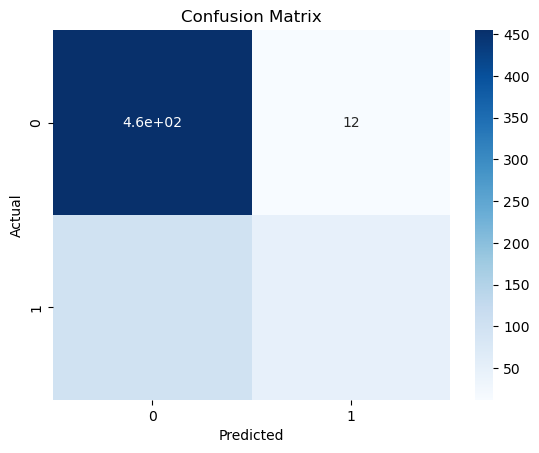

In [126]:
# EXTRA FOR FURTHER VALIDATION

from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {'C':[1,10, 100,500],
    'gamma':[0.1,1, 10,50],
    'kernel': ['rbf']
}

# Initialize SVM with RBF kernel
svm = SVC(probability=True)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='f1_macro', verbose=2)
grid_search.fit(svm_x, svm_y)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Evaluate the best model
y_pred = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
import seaborn as sns
confusion_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_mat, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

SVC(C=500, gamma=1, probability=True)
Accuracy: 0.86, Precision: 0.84, Recall: 0.51, F1-Score: 0.63


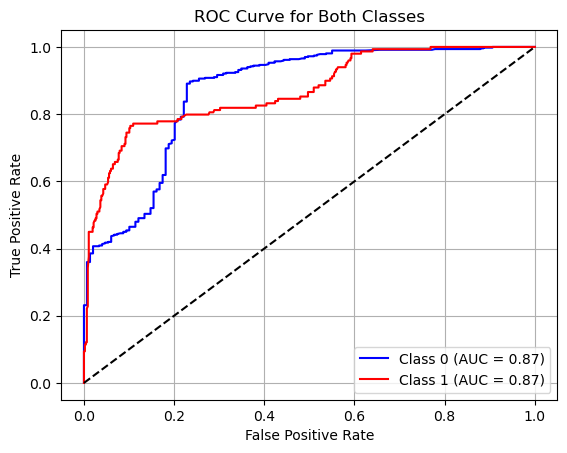

Class 0 AUC: 0.87
Class 1 AUC: 0.87


In [130]:
#making ROC
forROC=SVC(kernel='rbf', C=500, gamma=1, probability=True)
print(forROC)

clf, y_proba, y_pred=run_svm_rbf(X_test, y_test, forROC)
plot_roc_curves(y_test, y_proba)